In [ ]:
%pip install matplotlib

In [42]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import os
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
if os.environ.get('DISPLAY', '') == '':
    print('no display found. Using non-interactive Agg backend')
#     mpl.use('Agg')
import future.utils
mpl.rcParams["text.usetex"] = False
sns.set_style("whitegrid")
sns.axes_style("whitegrid")
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
import json
import numpy as np
import tqdm


no display found. Using non-interactive Agg backend


In [23]:
print('matplotlib: {}'. format(mpl.__version__))

matplotlib: 3.5.1


In [44]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

hex_list = ['#357db0', '#ce2626']
cmap=get_continuous_cmap(hex_list)

In [91]:
def from_res_to_iterations(name, nr):
    res = open("res/{}.csv".format(name))
    iterations = []
    it = 0
    for line in res.readlines():
        iterations.append(dict())
        iterations[it]['iteration'] = it
        iterations[it]['status'] = dict()

        opinions = line.strip().split(',')

        for i in range(len(opinions)):
            iterations[it]['status'][i] = float(opinions[i])
            iterations[it]['node_count'] = {0: 0},
            iterations[it]['status_delta'] = {0: 0}

        it += 1
        
    return iterations

hex_list = ['#357db0', '#18A558', '#ce2626']

def evolution(iterations, hex_list, fig, ax):

    """
    Generates the plot

    :param filename: Output filename
    :param percentile: The percentile for the trend variance area
    """

    nodes2opinions = {}
    node2col = {}

    last_it = iterations[-1]['iteration'] + 1
    last_seen = {}

    for it in iterations:
        sts = it['status']
        its = it['iteration']
        for n, v in sts.items():
            if n in nodes2opinions:
                last_id = last_seen[n]
                last_value = nodes2opinions[n][last_id]

                for i in range(last_id, its):
                    nodes2opinions[n][i] = last_value

                nodes2opinions[n][its] = v
                last_seen[n] = its
            else:
                nodes2opinions[n] = [0]*last_it
                nodes2opinions[n][its] = v
                last_seen[n] = 0
                if v < 0.33:
                    node2col[n] = hex_list[0]
                elif 0.33 <= v <= 0.66:
                    node2col[n] = hex_list[1]
                else:
                    node2col[n] = hex_list[2]

    mx = 0
    for k, l in future.utils.iteritems(nodes2opinions):
        if mx < last_seen[k]:
            mx = last_seen[k]
        x = list(range(0, last_seen[k]))
        y = l[0:last_seen[k]]
        ax.plot(x, y, lw=1.5, alpha=0.5, color=node2col[k])
    
    # ax.set_ylim(-0.1, 1.1)
    # ax.set_xlim(0, 1000)
    ax.tick_params(axis='both', which='major', labelsize=4, pad=0) 
    # ax.set_xlabel("o", fontsize=5)
    # ax.set_ylabel("t", fontsize=5)               
    # plt.grid(axis = 'both', which='both')
    plt.tight_layout()

    
from tqdm import tqdm

def spaghettigridbye(results, imgfolder):
    mops = list(results.media_op.unique())
    pmlist = sorted(list(results.p_media.unique()))
    elist = sorted(list(results.eps.unique()))
    glist=sorted(list(results.gam.unique()))
    sns.set_style("whitegrid")
    i=0
    if imgfolder == "moderate":
        mo = '0.5'
    for e in elist:
        fig, axes = plt.subplots(ncols=len(glist), nrows=len(pmlist), figsize=(6, 6), dpi=600, sharey=True)
        row=0
        for pm in pmlist:
            with tqdm(total=len(pmlist)*len(glist)) as pbar:
                col=0
                for g in glist:
                    name = f'for_spaghetti media mo[{mo}] p{pm} e{e} g{g} gm{g} mi1000000'
                    results = results[results['media_op']==mo]
                    results = results[results['eps']==e]
                    results = results[results['p_media']==pm]
                    results = results[results['gam']==g]
                    iterations = from_res_to_iterations(name, 1)
                    evolution(iterations, hex_list, fig=fig, ax=axes[row,col])
                    axes[row,col].set_title(r"$p_m$={}, $\epsilon$={}, $\gamma={}$".format(pm, e, g), fontsize=5)
                    col+=1    
            row+=1
            pbar.update(1)
        name = f'spaghetti media {imgfolder} e{e}'
        i+=1
        plt.savefig(f"plots/{imgfolder}/{name}.png")
        plt.close()

# Preliminaries

In [46]:
results = pd.read_csv("aggregate/results_media_model.csv", index_col=[0])

In [47]:
results = results[results['gam'] != 0.25]
results

n    p  eps   gam  gam_media  p_media   max_it       media_op  \
0    100  1.0  0.3  0.00       0.00      0.5  1000000      0.05;0.95   
1    100  1.0  0.2  0.75       0.75      0.5  1000000  0.05;0.5;0.95   
2    100  1.0  0.3  0.00       0.00      0.2  1000000      0.05;0.95   
3    100  1.0  0.4  1.25       1.25      0.2  1000000            0.5   
4    100  1.0  0.5  0.00       0.00      0.4  1000000            0.5   
..   ...  ...  ...   ...        ...      ...      ...            ...   
571  100  1.0  0.2  0.00       0.00      0.2  1000000      0.05;0.95   
572  100  1.0  0.5  1.25       1.25      0.2  1000000      0.05;0.95   
573  100  1.0  0.5  1.00       1.00      0.3  1000000            0.5   
574  100  1.0  0.5  0.75       0.75      0.0  1000000            0.0   
575  100  1.0  0.2  1.00       1.00      0.1  1000000            0.0   

     avg_ncluster  std_ncluster  ...  median_opinion  avg_00_perc  \
0        1.917247      0.139437  ...        0.547112       0.4966   
1        2.861434      0.253250  ...        0.500045       0.2843   
2        1.771977      0.290598  ...        0.512833       0.4441   
3        1.060078      0.065546  ...        0.500177       0.0178   
4        1.000000      0.000000  ...        0.500133       0.0000   
..            ...           ...  ...             ...          ...   
571      2.553017      0.391752  ...        0.489992       0.3250   
572      1.093833      0.103774  ...        0.526807       0.4770   
573      1.000000      0.000000  ...        0.500197       0.0000   
574      1.000408      0.004080  ...        0.505966       0.0002   
575      3.597519      1.527986  ...        0.513819       0.2319   

     avg_05_perc  avg_095_perc  avg_005_perc  10B_avg_entr  10B_std_entr  \
0         0.0048        0.4986        0.4966      0.682894      0.059351   
1         0.4315        0.2680        0.2843      1.182315      0.141936   
2         0.1297        0.4175        0.4441      0.593931      0.165382   
3         0.9721        0.0101        0.0178      0.266965      0.256676   
4         1.0000        0.0000        0.0000      0.024558      0.106782   
..           ...           ...           ...           ...           ...   
571       0.2376        0.3420        0.3250      0.962649      0.156338   
572       0.0000        0.5230        0.4770      0.153744      0.129727   
573       1.0000        0.0000        0.0000      0.143374      0.241776   
574       0.9908        0.0000        0.0002      0.030149      0.122832   
575       0.1590        0.0595        0.2319      1.308738      0.275436   

     100B_avg_entr  100B_std_entr  100B_norm_entr  
0         0.683276       0.060095        0.167361  
1         1.186385       0.145965        0.290592  
2         0.594069       0.165018        0.145511  
3         0.281470       0.264232        0.068943  
4         0.024558       0.106782        0.006015  
..             ...            ...             ...  
571       0.962649       0.156338        0.235790  
572       0.153744       0.129727        0.037658  
573       0.143374       0.241776        0.035118  
574       0.216650       0.258465        0.053066  
575       1.808828       0.459203        0.443053  

[576 rows x 29 columns]

In [48]:
gams = list(results.gam.unique())
p_medias = list(results.p_media.unique())
epss = list(results.eps.unique())
mos = list(results.media_op.unique())
print(gams, p_medias, epss, mos)

[0.0, 0.75, 1.25, 1.0, 0.5, 1.5] [0.5, 0.2, 0.4, 0.1, 0.3, 0.0] [0.3, 0.2, 0.4, 0.5] ['0.05;0.95', '0.05;0.5;0.95', '0.5', '0.0']


In [49]:
threemedia = results[results['media_op'] == '0.05;0.5;0.95']
print(len(threemedia))
gams = list(threemedia.gam.unique())
p_medias = list(threemedia.p_media.unique())
epss = list(threemedia.eps.unique())
mos = list(threemedia.media_op.unique())
print(gams, p_medias, epss, mos)

144
[0.75, 0.5, 1.0, 1.5, 1.25, 0.0] [0.5, 0.1, 0.4, 0.0, 0.2, 0.3] [0.2, 0.4, 0.5, 0.3] ['0.05;0.5;0.95']


In [50]:
twomedia = results[results['media_op'] == '0.05;0.95']
print(len(twomedia))
gams = list(twomedia.gam.unique())
p_medias = list(twomedia.p_media.unique())
epss = list(twomedia.eps.unique())
mos = list(twomedia.media_op.unique())
print(gams, p_medias, epss, mos)

144
[0.0, 1.5, 0.5, 1.0, 1.25, 0.75] [0.5, 0.2, 0.4, 0.3, 0.0, 0.1] [0.3, 0.4, 0.2, 0.5] ['0.05;0.95']


In [51]:
extremist = results[results['media_op'] == '0.0']
print(len(extremist))
gams = list(extremist.gam.unique())
p_medias = list(extremist.p_media.unique())
epss = list(extremist.eps.unique())
mos = list(extremist.media_op.unique())
print(gams, p_medias, epss, mos)

144
[1.25, 1.0, 0.0, 0.5, 0.75, 1.5] [0.1, 0.3, 0.0, 0.2, 0.5, 0.4] [0.3, 0.5, 0.2, 0.4] ['0.0']


In [52]:
moderate = results[results['media_op'] == '0.5']
print(len(moderate))
gams = list(moderate.gam.unique())
p_medias = list(moderate.p_media.unique())
epss = list(moderate.eps.unique())
mos = list(moderate.media_op.unique())
print(gams, p_medias, epss, mos)

144
[1.25, 0.0, 1.0, 0.75, 1.5, 0.5] [0.2, 0.4, 0.5, 0.0, 0.3, 0.1] [0.4, 0.5, 0.2, 0.3] ['0.5']


In [53]:
deffuant = results[results['gam']==0.0]

In [54]:
measures = list(deffuant.columns)[8:]

In [55]:
print(measures)

['avg_ncluster', 'std_ncluster', 'avg_pwdist', 'std_pwdist', 'avg_niter', 'std_niter', 'avg_ncluster_0.001', 'std_ncluster_0.001', 'nruns', 'avg_opinion', 'std_opinions', 'median_opinion', 'avg_00_perc', 'avg_05_perc', 'avg_095_perc', 'avg_005_perc', '10B_avg_entr', '10B_std_entr', '100B_avg_entr', '100B_std_entr', '100B_norm_entr']


# Bounded confidence model with media

### Heatmap plot

In [ ]:
sns.set(font_scale=1.6)
for measure in ['avg_05_perc']:
    print(measure)
    i=0
    for mo in ['0.5', '0.0', '0.05;0.95', '0.05;0.5;0.95']:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), dpi=600)
        titles = ['moderate', 'extremist', 'polarized', 'balanced']
        x = "p_media"
        y = "eps"
        data = deffuant[deffuant["media_op"]==mo]
        df = data.pivot(x, y, measure)
        a=sns.heatmap(df, cbar=True, fmt=".2f", annot=True, ax = ax, cmap=cmap)
        ax.set_xlabel(r'$\epsilon$', fontsize=30)
        ax.set_ylabel(r'$p_m$', fontsize=30)
        plt.savefig(f'{measure}_{titles[i]}_deffuant_heatmap.png')
        i+=1


### Surface plots

In [ ]:
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
for measure in ['avg_05_perc']:
    print(measure)
    i=0
    for mo in ['0.5', '0.0', '0.05;0.95', '0.05;0.5;0.95']:
        titles = ['moderate', 'extremist', 'polarized', 'balanced']
        x = "p_media"
        y = "eps"
        data = deffuant[deffuant["media_op"]==mo]
        fig = plt.figure(figsize=(15, 10))
        ax = fig.gca(projection='3d')
        ax.plot_trisurf(data['eps'], data['p_media'], data[measure], vmin=min(deffuant[measure]), vmax=max(deffuant[measure]), cmap=cmap, linewidth=0.0, alpha=0.8)
        surf=ax.plot_trisurf(data['eps'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
        # fig.colorbar(surf, shrink=0.5, aspect=6).ax.tick_params(labelsize=22)
        ax.set_xlabel(r'$\epsilon$', fontsize=40, labelpad=30)
        ax.set_ylabel(r'$p_m$', fontsize=50, labelpad=30)
        ax.tick_params(axis='x', which='major', labelsize=22, pad=2, labelrotation=45)
        ax.tick_params(axis='y', which='major', labelsize=22, pad=10)
        ax.tick_params(axis='z', which='major', labelsize=22, pad=10)  
        ax.set_zlim(0.0, 1.0) 
        plt.savefig(f'{measure}_{titles[i]}_deffuant_surface.png')
        i+=1                

# A single - moderate - media

In [56]:
moderate.head()

n    p  eps   gam  gam_media  p_media   max_it media_op  avg_ncluster  \
3   100  1.0  0.4  1.25       1.25      0.2  1000000      0.5      1.060078   
4   100  1.0  0.5  0.00       0.00      0.4  1000000      0.5      1.000000   
5   100  1.0  0.4  1.25       1.25      0.4  1000000      0.5      1.082641   
6   100  1.0  0.2  1.00       1.00      0.2  1000000      0.5      3.576107   
19  100  1.0  0.5  0.75       0.75      0.4  1000000      0.5      1.000000   

    std_ncluster  ...  median_opinion  avg_00_perc  avg_05_perc  avg_095_perc  \
3       0.065546  ...        0.500177       0.0178       0.9721        0.0101   
4       0.000000  ...        0.500133       0.0000       1.0000        0.0000   
5       0.062735  ...        0.500228       0.0204       0.9617        0.0179   
6       0.867551  ...        0.501146       0.0437       0.4579        0.1013   
19      0.000000  ...        0.500154       0.0000       1.0000        0.0000   

    avg_005_perc  10B_avg_entr  10B_std_entr  100B_avg_entr  100B_std_entr  \
3         0.0178      0.266965      0.256676       0.281470       0.264232   
4         0.0000      0.024558      0.106782       0.024558       0.106782   
5         0.0204      0.323349      0.266925       0.341282       0.270358   
6         0.1016      1.440886      0.198281       1.930834       0.306728   
19        0.0000      0.174462      0.251726       0.174462       0.251726   

    100B_norm_entr  
3         0.068943  
4         0.006015  
5         0.083593  
6         0.472937  
19        0.042733  

[5 rows x 29 columns]

### Heatmap plot

In [57]:
measures = [
 'avg_pwdist',
 'std_pwdist',
 'avg_niter',
 'std_niter',
 'avg_ncluster_0.001',
 'std_ncluster_0.001',
 'avg_opinion',
 'std_opinions',
 'avg_05_perc',
 '100B_avg_entr',
 '100B_std_entr',
 '100B_norm_entr']

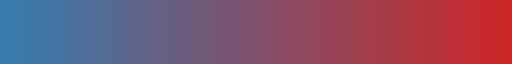

In [58]:
cmap

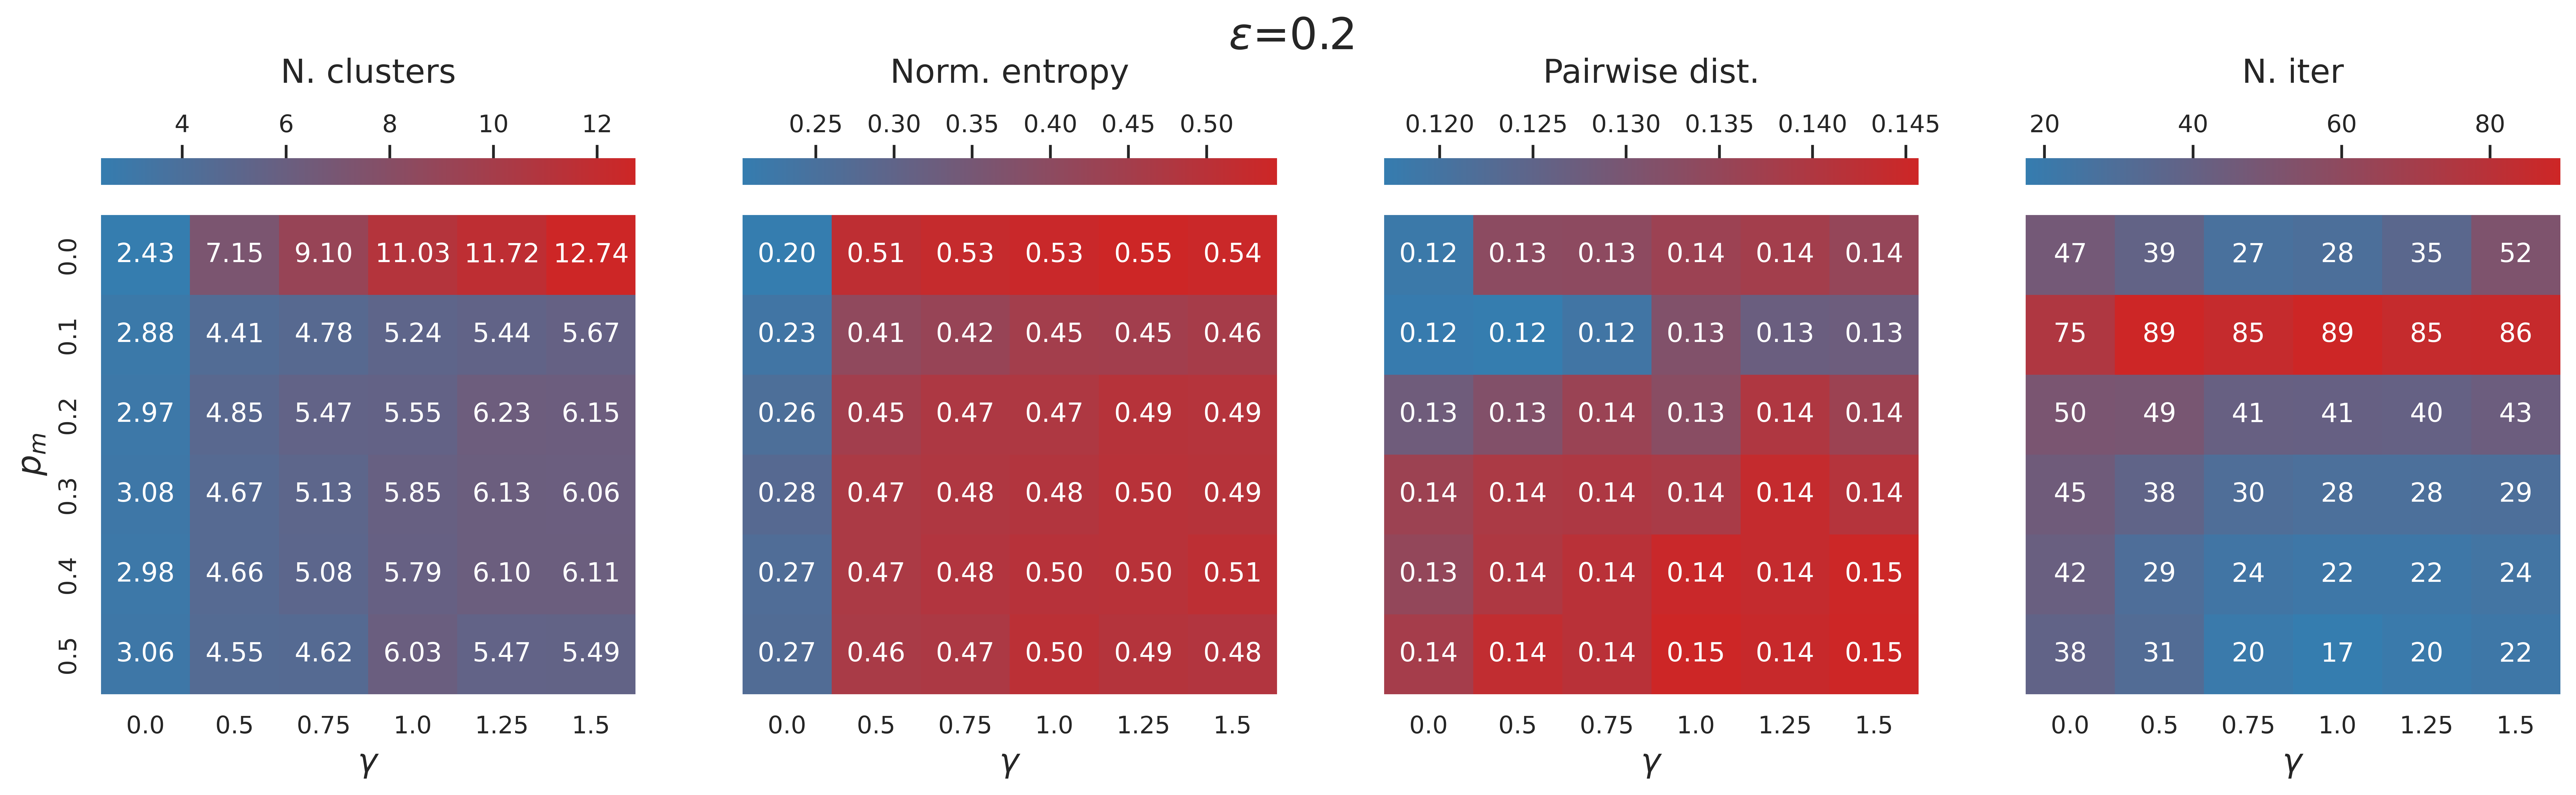

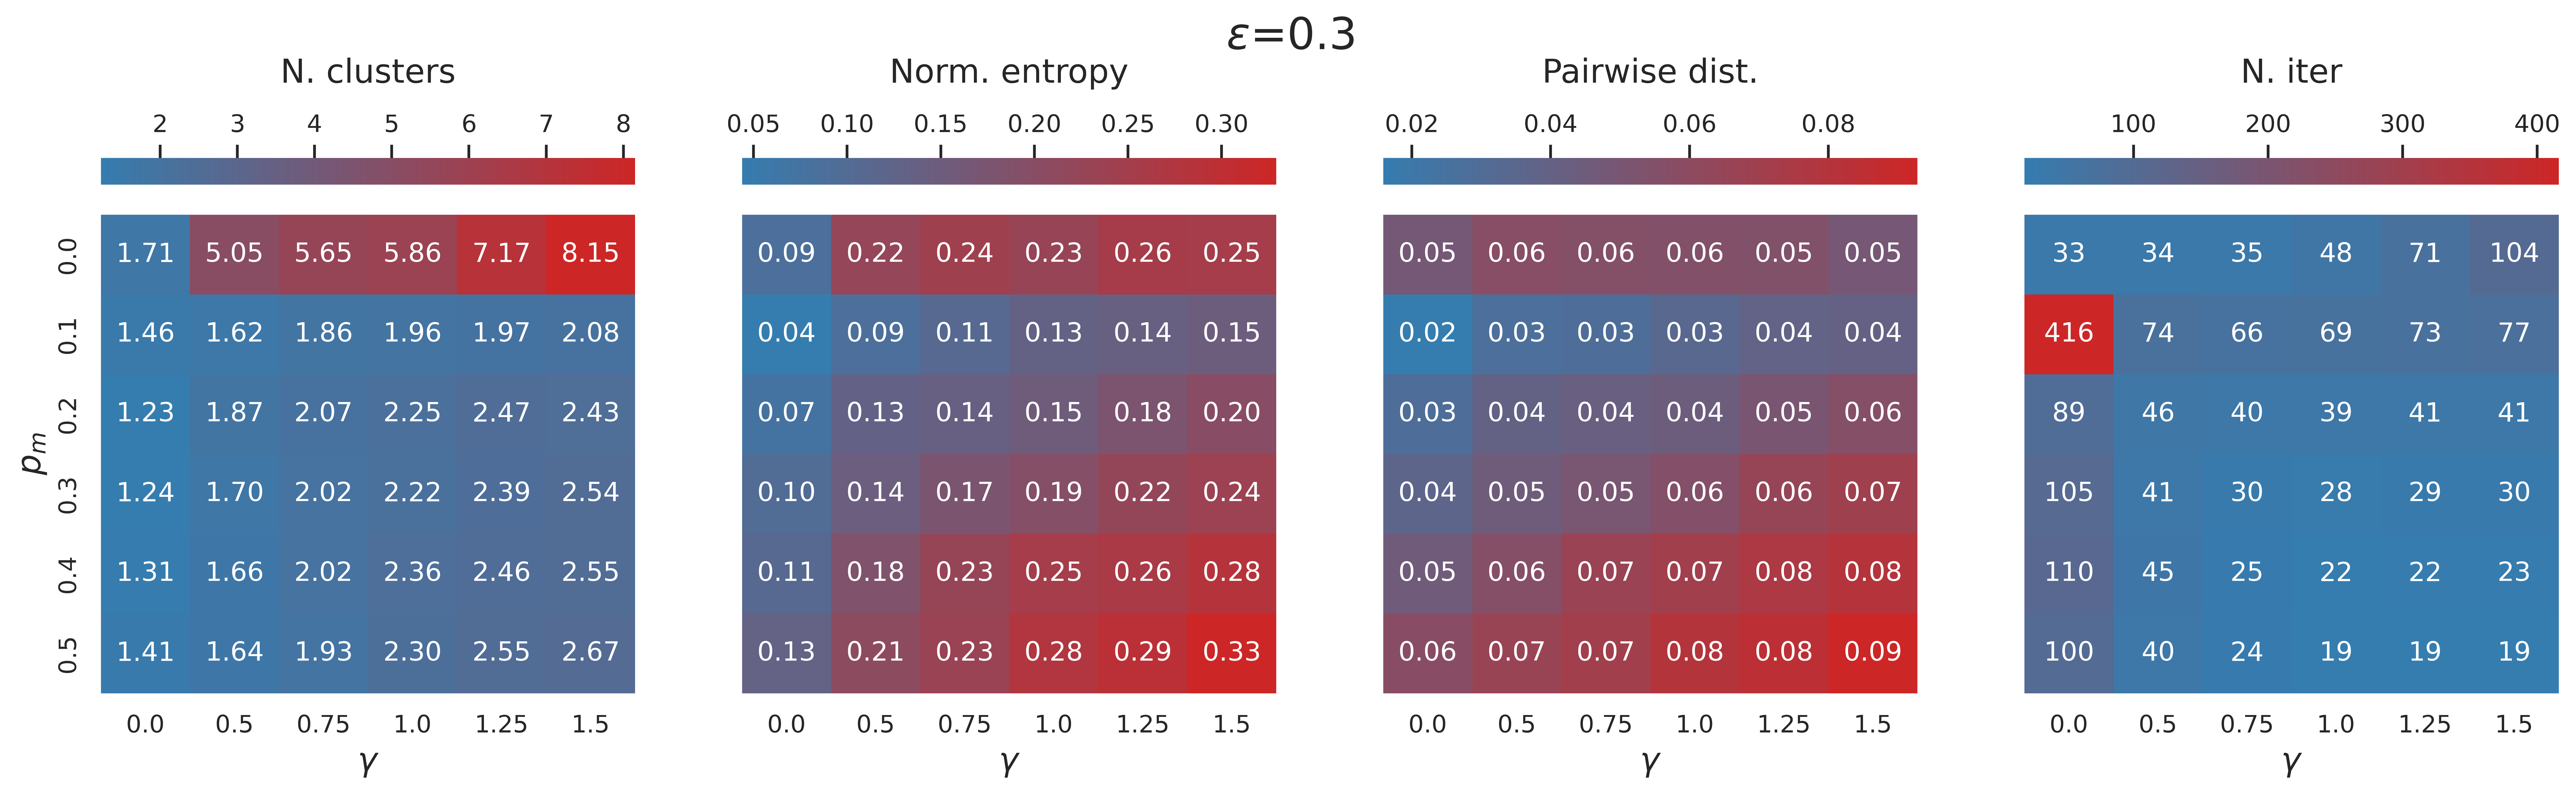

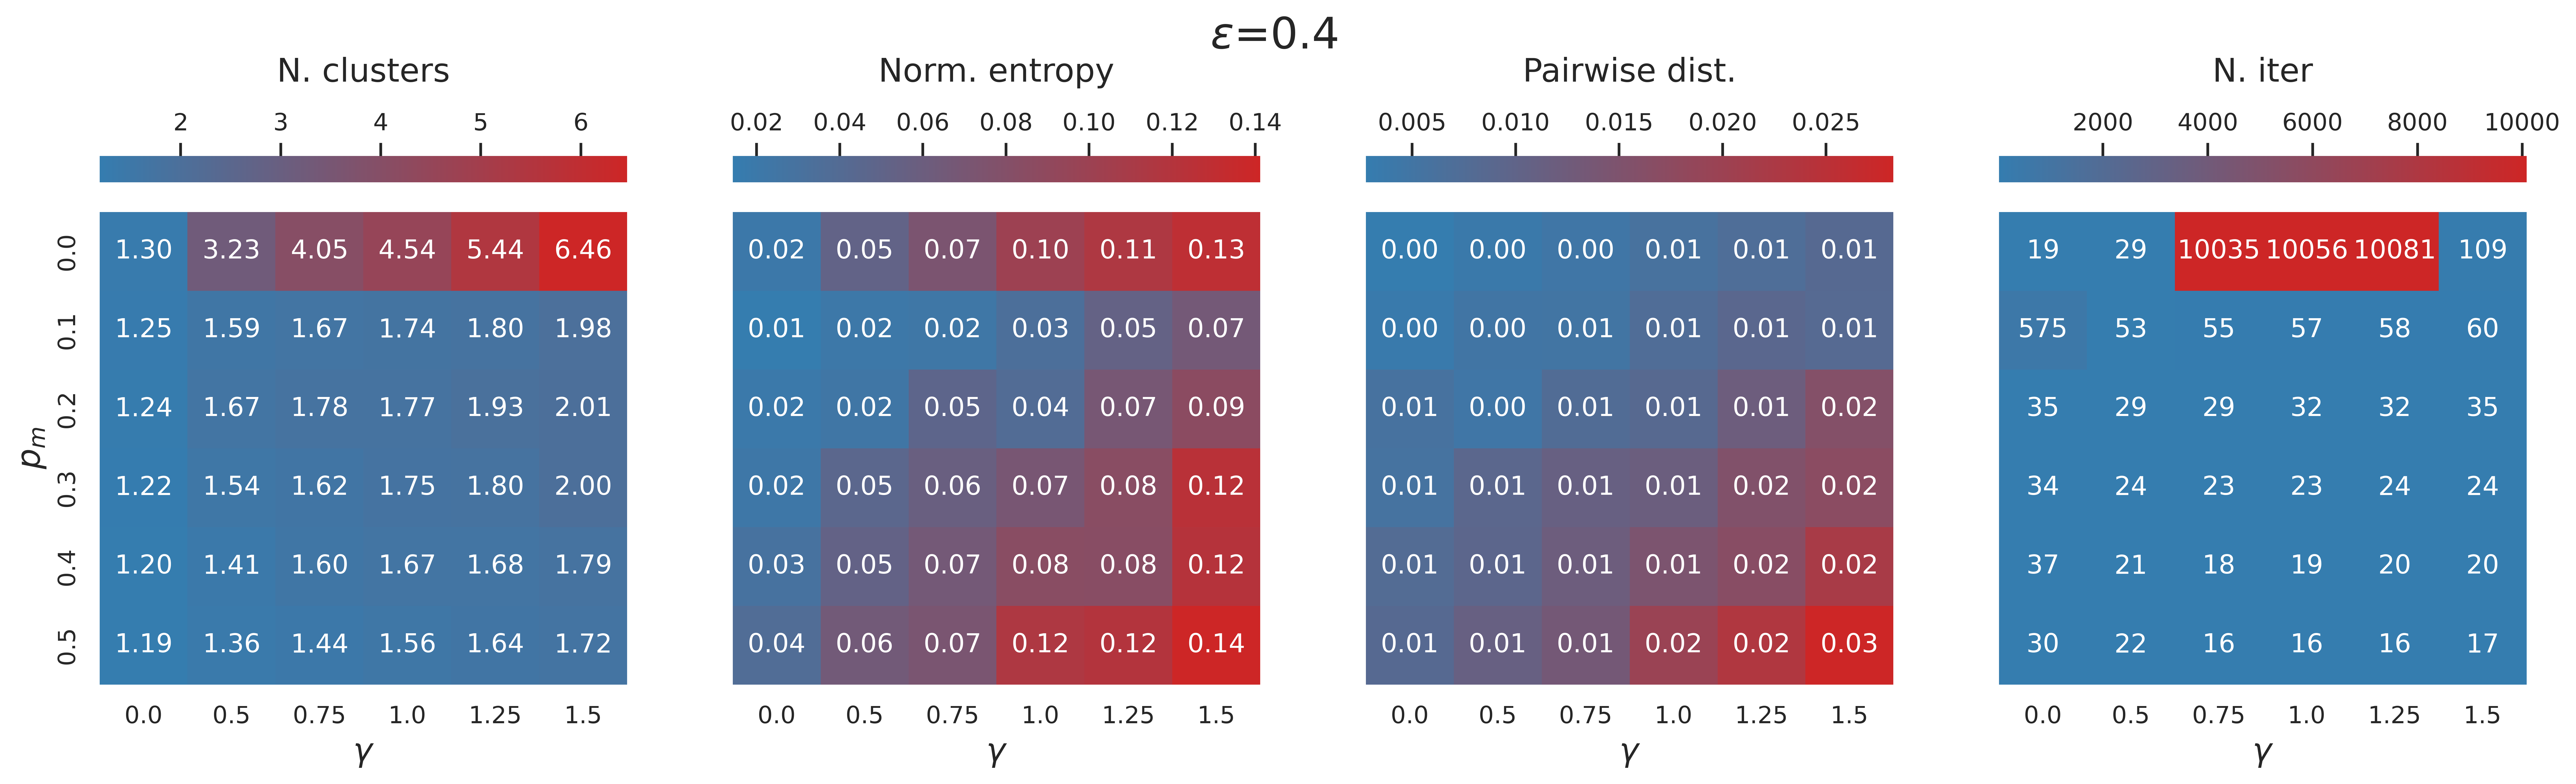

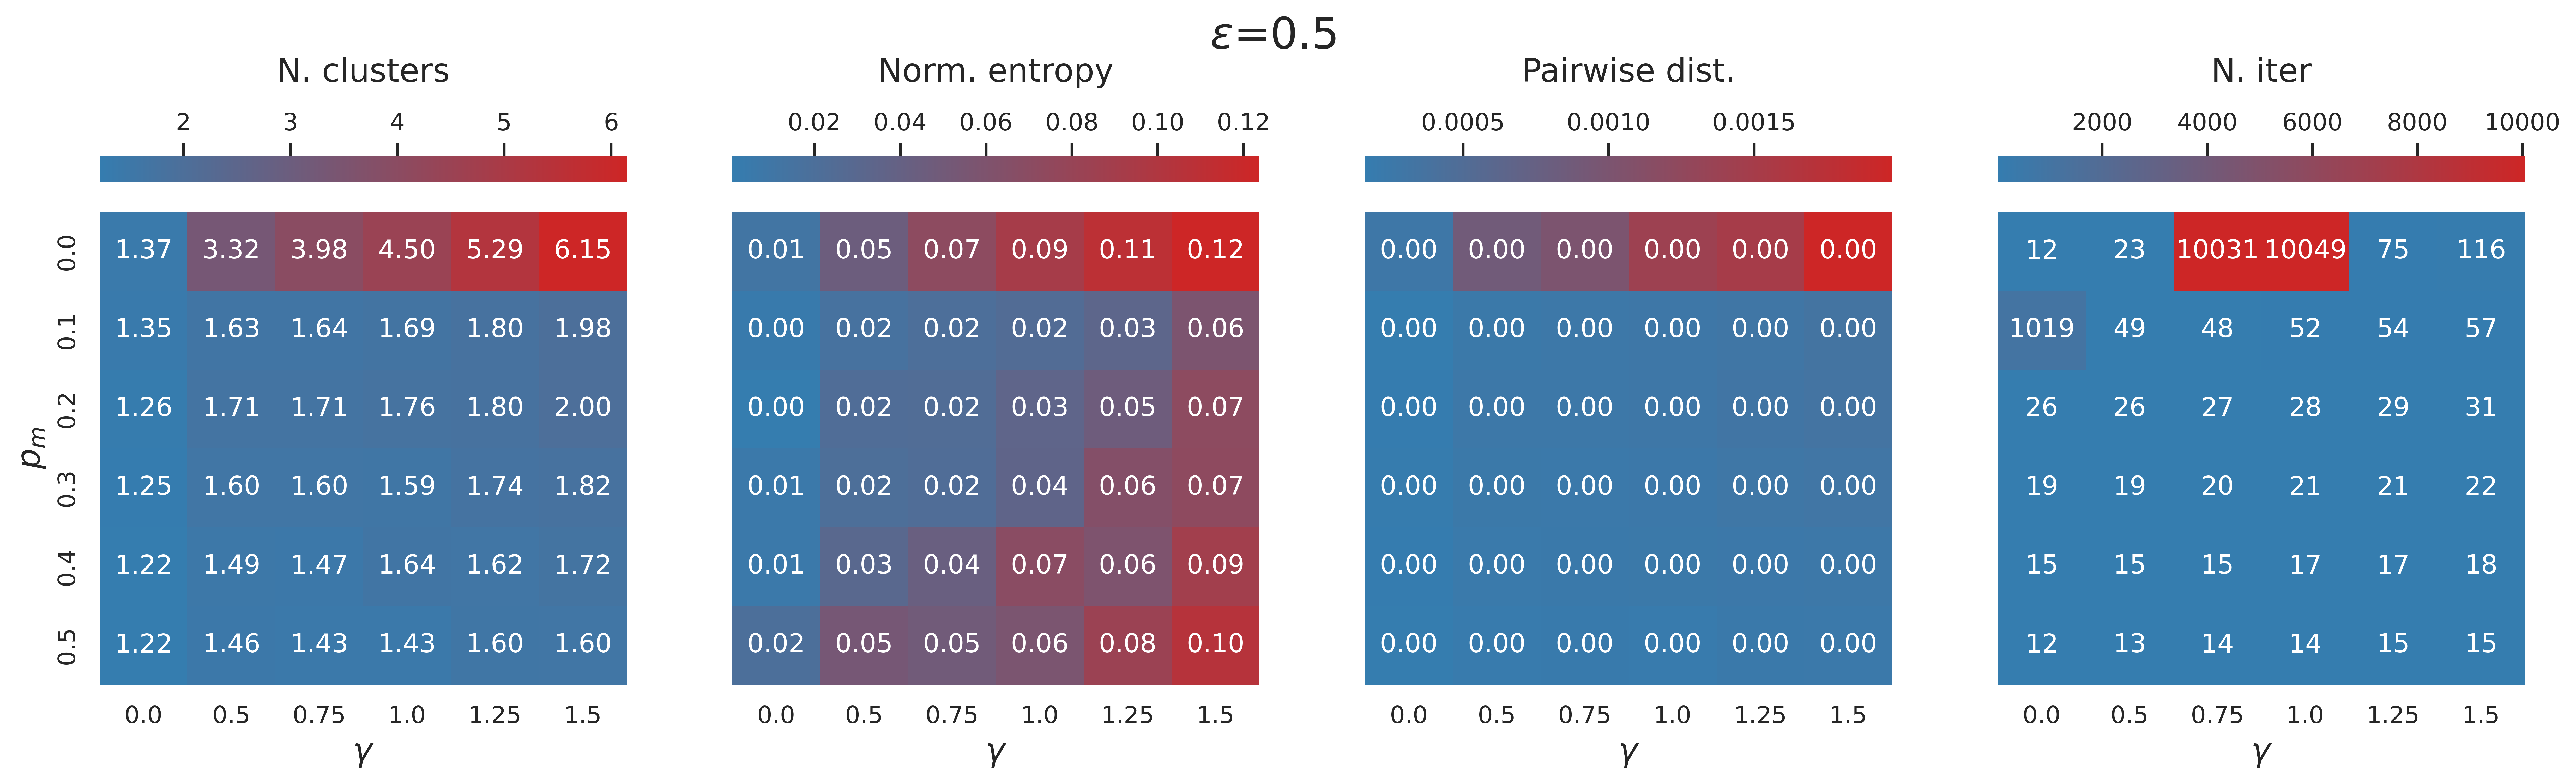

In [84]:
sns.set(font_scale=1.0)
for eps in sorted(moderate.eps.unique()):
    i=0
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), dpi=600, sharey=True)
    for measure in ['avg_ncluster_0.001', '100B_norm_entr', 'avg_pwdist', 'avg_niter']:
        titles = ['N. clusters', 'Norm. entropy', 'Pairwise dist.', 'N. iter']
        x = "p_media"
        y = "gam"
        data = moderate[moderate["eps"]==eps]
        df = data.pivot(x, y, measure)
        if measure == "avg_niter":
            a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".0f", annot=True, ax = axes[i], cmap=cmap, vmin=min(data[measure]), vmax=max(data[measure]))
        else:
            a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = axes[i], cmap=cmap, vmin=min(data[measure]), vmax=max(data[measure]))
        axes[i].set_xlabel(r'$\gamma$', fontsize=15)
        axes[i].set_ylabel('', fontsize=15)
        axes[i].set_title(f'{titles[i]}', fontsize=15, pad = 60)
        i+=1
    axes[0].set_ylabel(r'$p_m$', fontsize=15)
    fig.suptitle(r"$\epsilon$={}".format(eps), fontsize=20)
    # plt.savefig(f'{measure}_moderate_e{eps}_heatmap.png')
    plt.show()
    plt.close()


Text(1299.5, 0.5, '$p_m$')

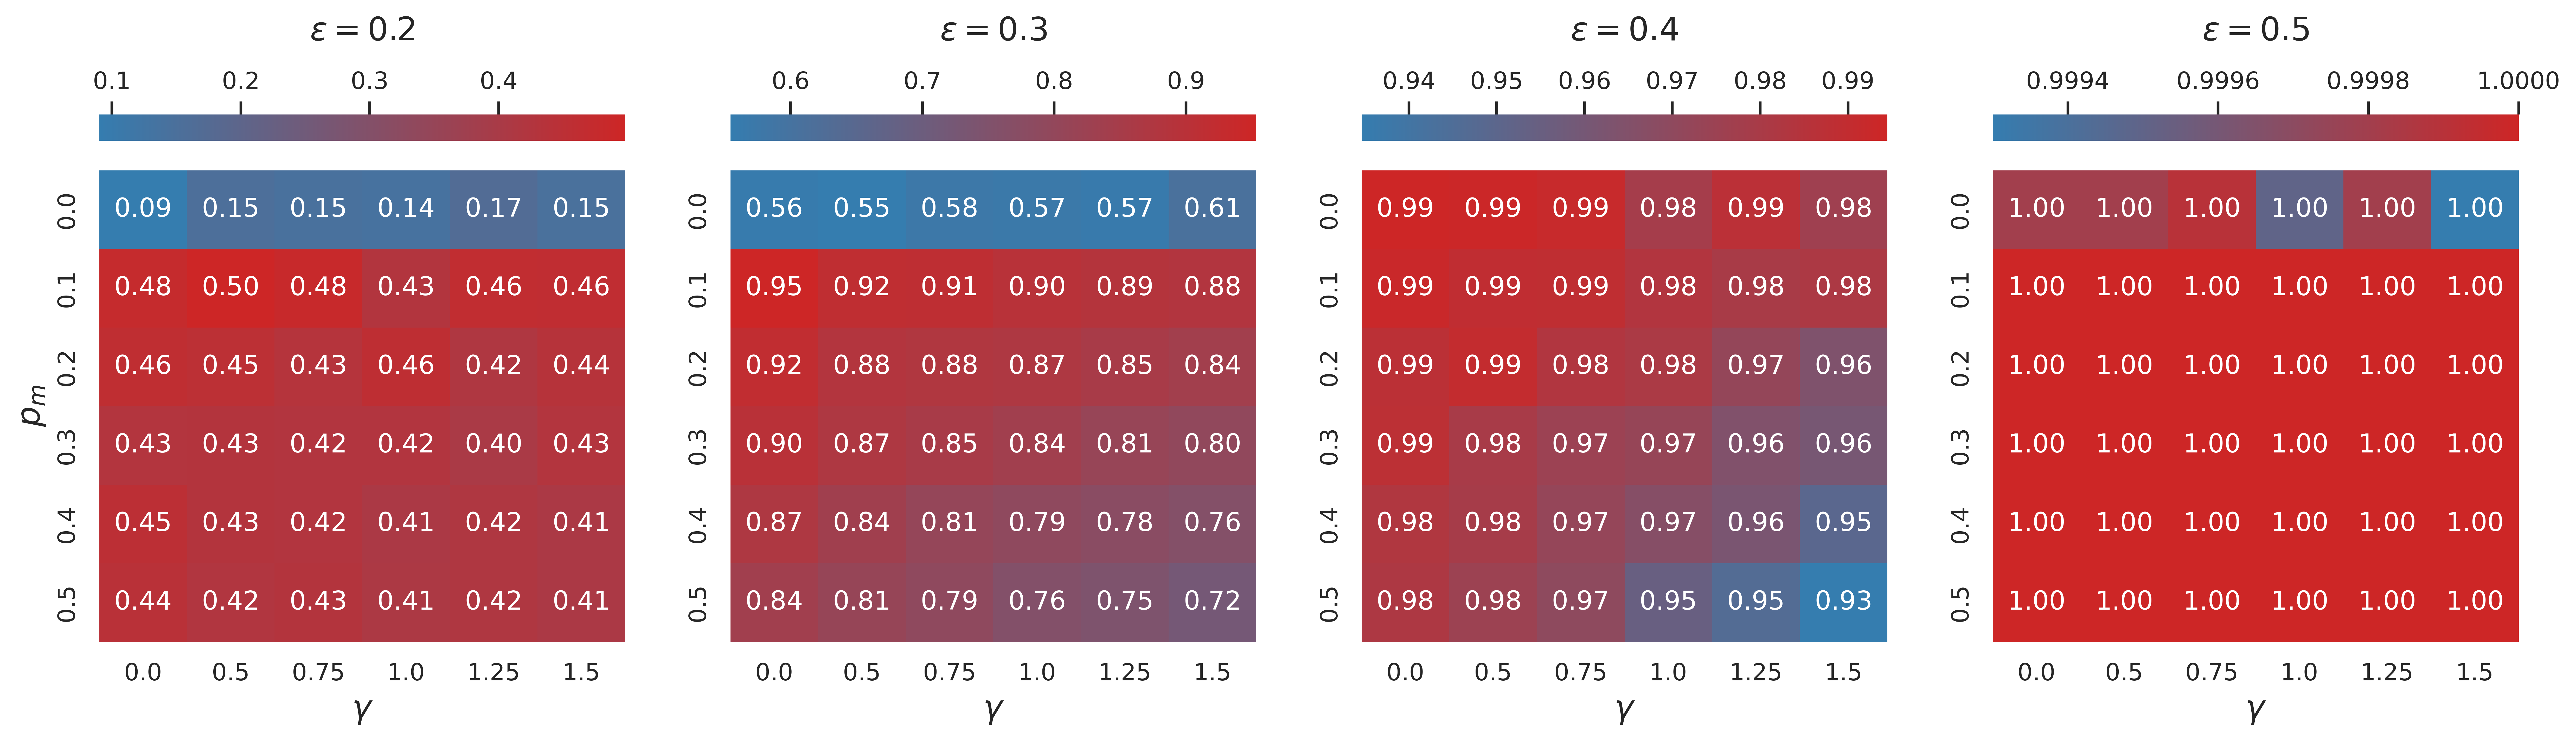

In [89]:
x = "p_media"
y = "gam"
fig, axes = plt.subplots(nrows=1, ncols=4, dpi=600, figsize=(20, 5))
i=0
for eps in sorted(moderate.eps.unique()):
    data = moderate[moderate["eps"]==eps]
    df = data.pivot(x, y, 'avg_05_perc')
    a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = axes[i], cmap=cmap)
    axes[i].set_xlabel(r'$\gamma$', fontsize=15)
    axes[i].set_ylabel('', fontsize=15)
    axes[i].set_title(r'$\epsilon={}$'.format(eps), fontsize=15, pad = 60)
    i+=1
axes[0].set_ylabel(r'$p_m$')

# Extremist media - propaganda

# Polarised media landscape

### Per extended abstract

In [ ]:
twomedia

In [ ]:
measures

In [ ]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
for measure in ['avg_ncluster_0.001']:
    print(measure)
    i=0
    x = "gam"
    y = "p_meda"
    data = twomedia[twomedia["eps"]==0.3]
    fig = plt.figure(figsize=(15, 10))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    surf=ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    # fig.colorbar(surf, shrink=0.5, aspect=6).ax.tick_params(labelsize=22)
    ax.set_xlabel(r'$\gamma$', fontsize=40, labelpad=30)
    ax.set_ylabel(r'$p_m$', fontsize=50, labelpad=30)
    ax.tick_params(axis='x', which='major', labelrotation=45)
    ax.tick_params(axis='y', which='major', pad=10)
    ax.tick_params(axis='z', which='major', pad=10)  
    plt.show()
    # plt.savefig(f'{measure}_{titles[i]}_deffuant_surface.png')
    i+=1       

In [ ]:
%ls

In [ ]:
for e in [0.32]:
    for g in [0.0, 1.6]:
        for pm in [0.0, 0.5]:
            fig, ax = plt.subplots(nrows=1, ncols=1, dpi=600, figsize=(7, 5))
            mo = '0.05, 0.95'
            name = f'for_spaghetti/for_spaghetti media mo[{mo}] p{pm} e{e} g{g} gm{g} mi1000000'
            results = results[results['media_op']==mo]
            results = results[results['eps']==e]
            results = results[results['p_media']==pm]
            iterations = from_res_to_iterations(name, 1)
            evolution(iterations, hex_list, fig=fig, ax=ax)
            plt.axis('off')
            plt.title(r'$\epsilon$='+f'{e},'+r'$\gamma$='+f'{g},'+r'$p_m$='+f'{pm}')
            plt.show()

In [ ]:
for e in [0.32]:
    for g in [1.6]:
        for pm in [0.5]:
            fig, ax = plt.subplots(nrows=1, ncols=1, dpi=600, figsize=(7, 5))
            mo = '0.05, 0.95'
            name = f'for_spaghetti/for_spaghetti media mo[{mo}] p{pm} e{e} g{g} gm{g} mi1000000 new new'
            results = results[results['media_op']==mo]
            results = results[results['eps']==e]
            results = results[results['p_media']==pm]
            iterations = from_res_to_iterations(name, 1)
            evolution(iterations, hex_list, fig=fig, ax=ax)
            plt.axis('off')
            plt.title(r'$\epsilon$='+f'{e},'+r'$\gamma$='+f'{g},'+r'$p_m$='+f'{pm}')
            plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 1), dpi=600)
fig.subplots_adjust(bottom=0.5)

cmap = cmap
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal')
cb.outline.set_visible(False)
cb.set_ticks([0.0, 1.0])


# Balanced media landscape